In [2]:
###### bibliotecas padrao ######
import pandas as pd #csv, dataframes
import numpy as np

###### bibliotecas para preparacao dos dados ######
#expressoes regulares
import re 
#vetorizacao via BoW
from sklearn.feature_extraction.text import CountVectorizer 


###### bibliotecas para o modelo de classificacao ######
#divisão de dados para treino/teste
from sklearn.model_selection import train_test_split
#aprendizagem supervisionada com multiplas classes/funciona bem com BoW
from sklearn.naive_bayes import MultinomialNB 

* Observação 1: Notebook de referência: https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp
* Observação 2: Fui escrevendo este notebook de forma simultânea aos estudos. Achei essa metodologia necessária uma vez que este é meu primeiro contato com RegEx, NLP e ML. O que não foi totalmente entendido possui um "?"

<h1>Sumário</h1>

* Importando e limpando os dados<br> 
* Preparação dos dados<br>
 * RegEx<br>
* Modelo<br>
 * Vetorização<br> 
   * Modelos de vetorização
     * BoW<br>
     * TD - IDF<br>
* Treinamento<br>
* Teste<br>
* Análise de Sentimento com todas as reviews
* Respostas das Tarefas

<h1>Database Schema Design</h1>

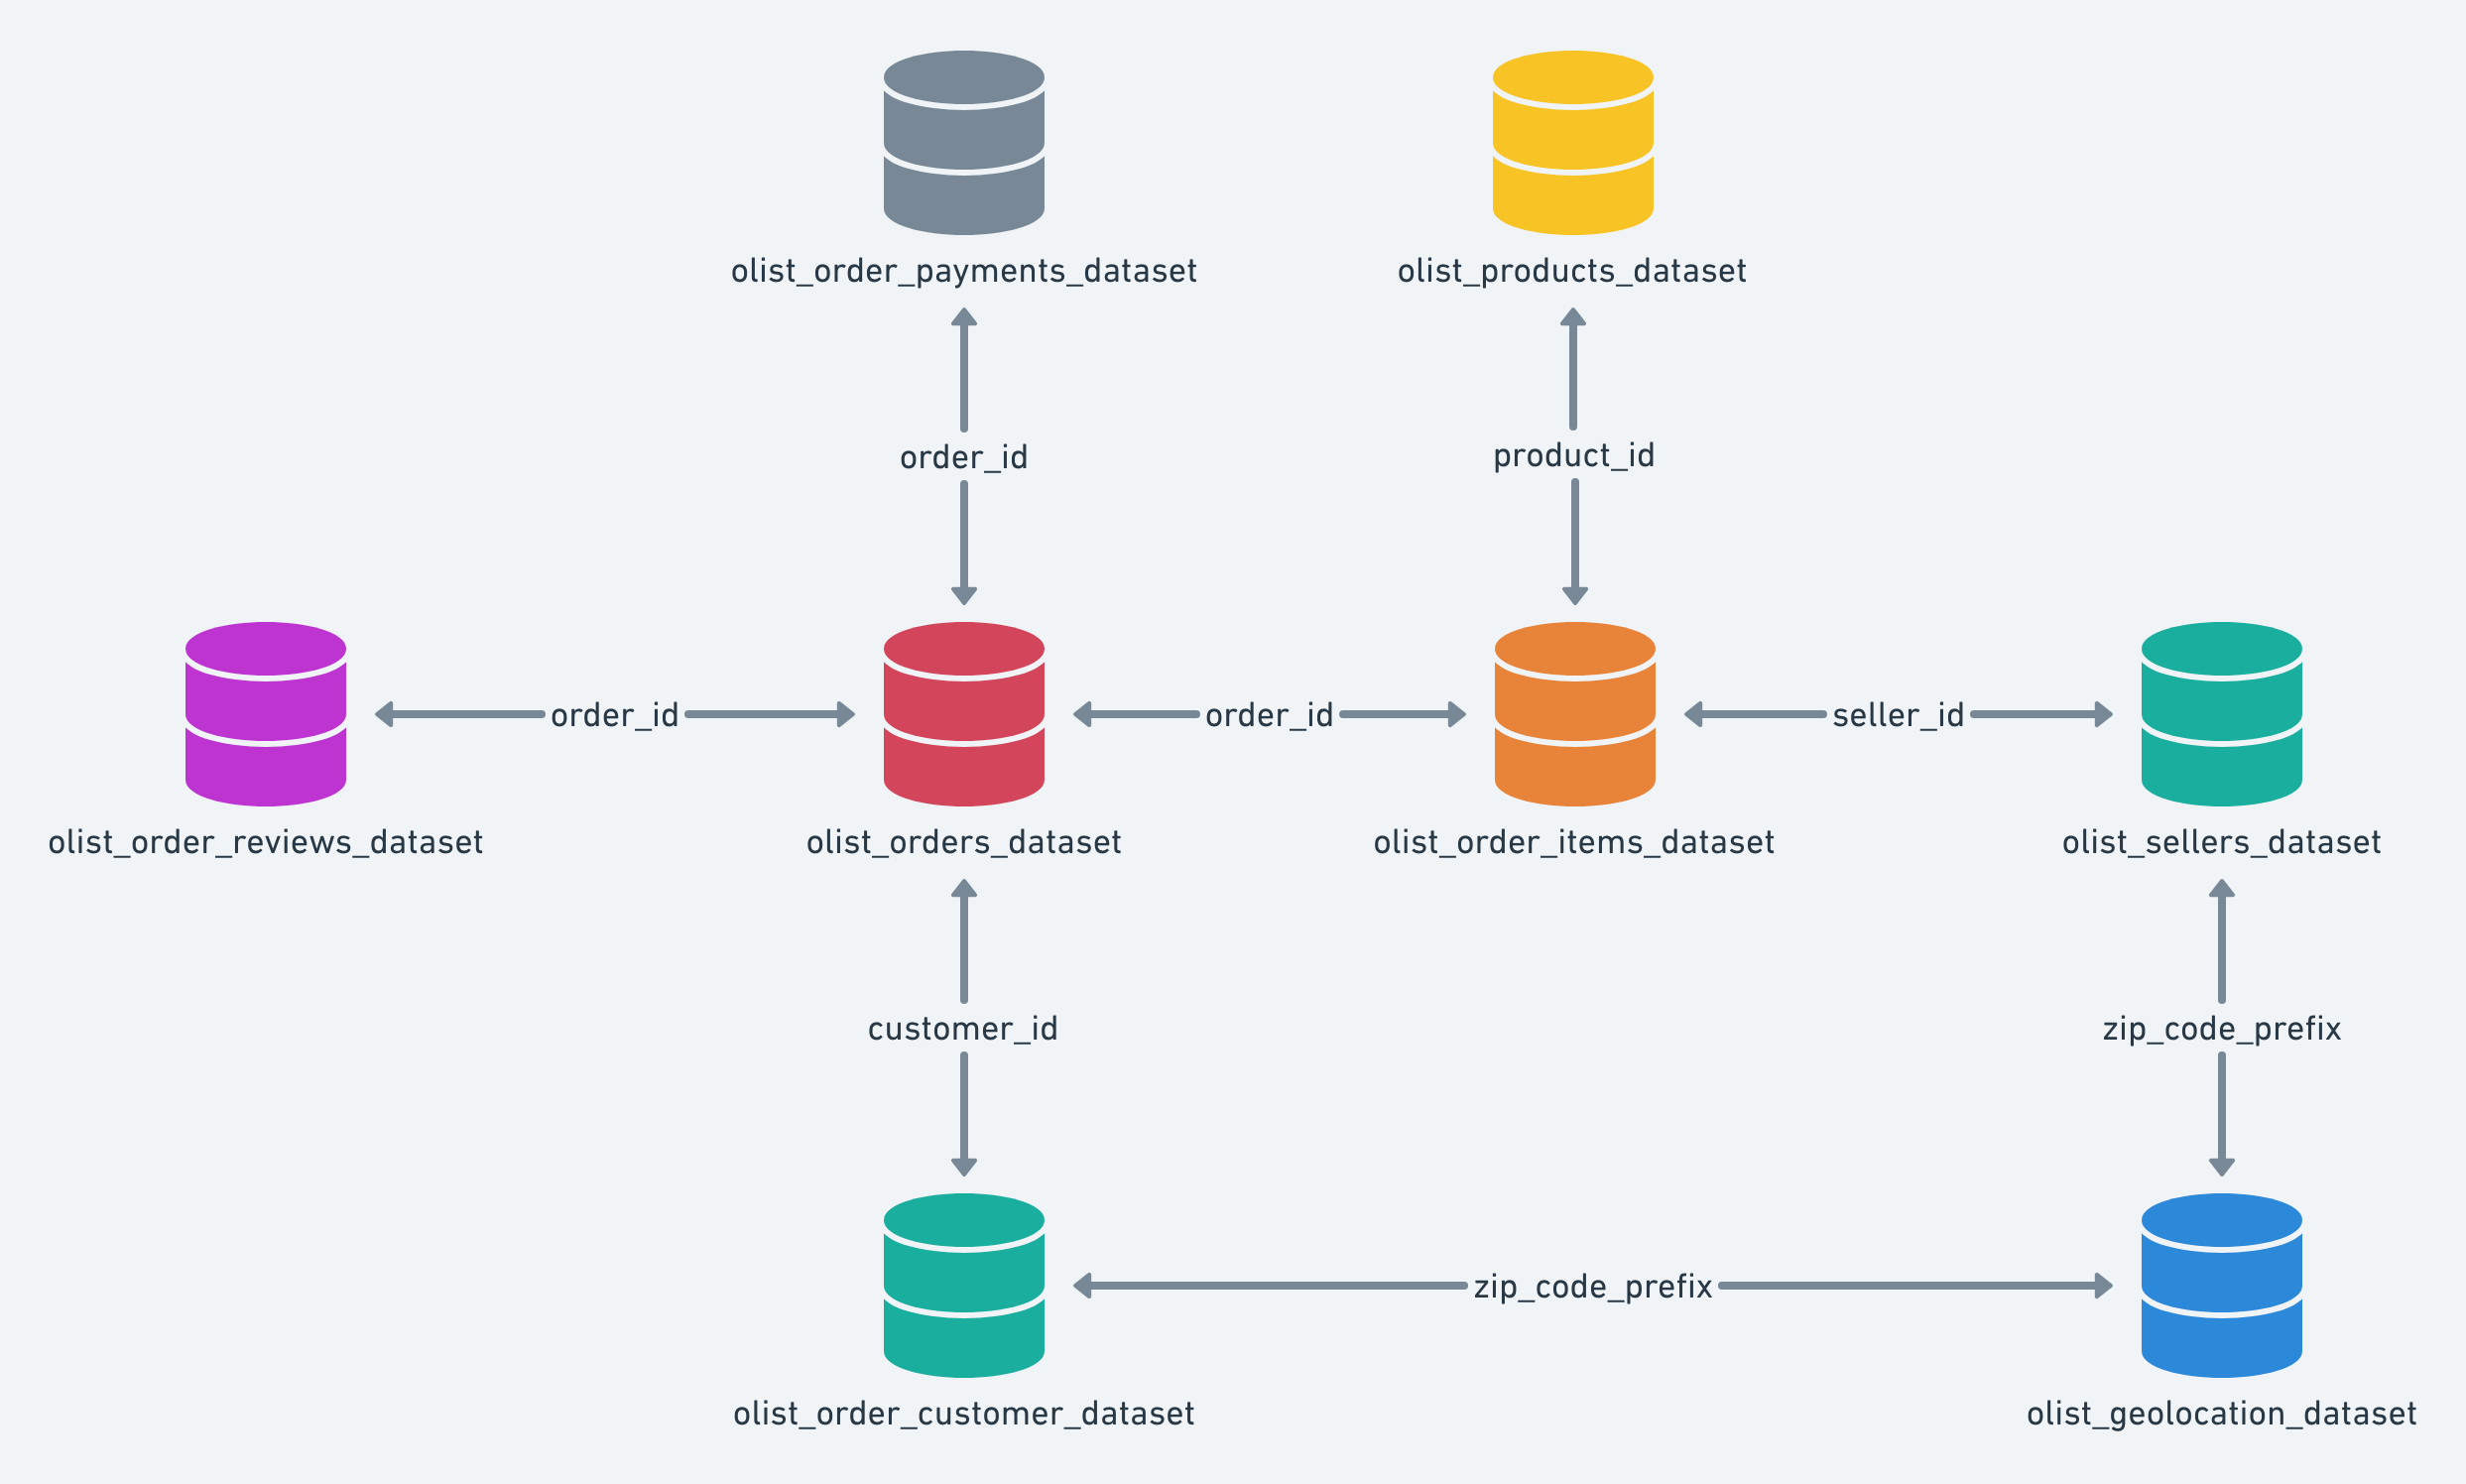[](http://)

Database Schema de um banco de dados corresponde a estrutura formal do mesmo e refere-se à a organização do banco de dados em forma de diagrama, e determina como o banco de dados é construído (<a href = 'https://pt.wikipedia.org/wiki/Esquema_de_banco_de_dados'>Wikipedia</a>).

<h1>Importando e limpando os dados</h1>

Os <a href = "https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp">dados</a> referem-se ao e-commerce no território brasileiro entre 09/2016 até 10/2018. Os arquivos de interesse chamam-se (1) 'olist_order_reviews_dataset.csv', (2) 'olist_products_dataset.csv' e (3) 'olist_order_payments_dataset.csv' e contém informações sobre os reviews, sobre as ordens de compra e sobre os produtos vendidos no e-commerce no Brasil no mesmo intervalo temporal.
* As colunas de interesse (review_score, reviews_message, product_id, product_category_name, order_id), e seus respectivos datasets podem ser encontrados do Data Schemma

In [3]:
#importando os dados de interesse
#df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv', 
#                 usecols = ['review_score','review_comment_message', 'order_id'])

df_reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv', 
                 usecols = ['review_score','review_comment_message'])

df_prod = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv', usecols = ['product_id', 'product_category_name'])

df_order = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv', 
                 usecols = ['order_id'])

#renomeando colunas
df_reviews.columns = ['score', 'comentarios']
df_prod.columns = ['prod_id', 'prod_categoria']
#df_order.columns = ['order_id']

#concatenando os dados de interesse
df = pd.concat([df_reviews, df_prod, df_order], axis = 1, join = 'inner' )

df

,score,comentarios,prod_id,prod_categoria,order_id
0,4,NaN,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,b81ef226f3fe1789b1e8b2acac839d17
1,5,NaN,3aa071139cb16b67ca9e5dea641aaa2f,artes,a9810da82917af2d9aefd1278f1dcfa0
2,5,NaN,96bd76ec8810374ed1b65e291975717f,esporte_lazer,25e8ea4e93396b6fa0d3dd708e76c1bd
3,5,Recebi bem antes do prazo estipulado.,cef67bcfe19066a932b7673e239eb23d,bebes,ba78997921bbcdc1373bb41e913ab953
4,5,Parabéns lojas lannister adorei comprar pela I...,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,42fdf880ba16b47b59251dd489d4441a
...,...,...,...,...,...
32946,5,NaN,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,87386e2485df1ab61a6d060a092e4d6f
32947,1,"Ainda está no prazo, produto está incompleto",bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,6b492e90666acecd3f5d1fd3fab7afbf
32948,4,Otimo nao tive problemas nota 9,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,bcc8085a0288cf3353fea3d79ae6b9a0
32949,4,As almofadas são de excelente qualidade e foi ...,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,0f6c56738e9a7a30c78b735a231d3f56


In [4]:
#removendo dados ausentes do dataframe
df.dropna(inplace = True)

#resetando índice
df.reset_index(inplace = True, drop = True)

#imprime tuple(#linhas,#colunas)
df.shape

(13603, 5)

<h1>Preparação dos dados</h1>

Segundo <a href = "https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp"> Panini</a>, para fazer a análise sentimental é necessário preparar os dados e transformá-los em vetores, para que por fim sejam interpretados por um modelo de Machine Learning. A preparação consiste, dentre outros passos, em aplicar Expressões Regulares (RegEx) no conjunto de dados, afim de identificar padrões e extraí-los. A vetorização depende do modelo utilizado, e consiste em representar palavras vetorialmente em função da sua frequência em um documento e/ou de sua importância.

<h2>RegEx</h2>

Vários processos de RegEx são necessários para preparar os dados para análise, bem como processos como stemming (redução da palavra ao seu tronco) e remoção de stopwords (palavras irrelevantes). Aqui estou reproduzindo apenas alguns

* Criar uma função que substitua as quebras de linhas encontradas nos textos por espaços em branco
* Criar uma função que substitua os valores numéricos pela palavra 'numero' (Mas, por qual motivo exatamente ?)
* Criar uma função que substitua caracteres especiais por espaços em branco

In [5]:
def reQuebraDeLinha(texto_lista):
    #quebras de linha - \n\r
    #re.sub -> expressão regular que substitui um padrão por outro
    
    texto_lista = [re.sub('\r\n',' ', i) for i in texto_lista]   # list comprehension para substituir
                                                                 # as quebras de linha por espaços em branco
    return texto_lista

In [6]:
def numTransform(texto_lista):
    #[] indica quais caracteres estou considerando
    #0-9 -> numeros no intervalo (0,9)
    #'+' -> na documentação diz que significa que o que estiver imediatamente antes dele precisa aparecer 1 ou mais vezes,
    #       porém não entendi muito bem. Mas sem o + na RegEx a palavra 'numero' se repete
    
    texto_lista = [re.sub('[0-9]+', 'numero ', i) for i in texto_lista]
    return texto_lista

In [7]:
def charEsp(texto_lista):
    #\W caracter nao alfa-numerico (^[a-zA-Z0-9])
    texto_lista = [re.sub('\W', ' ', i) for i in texto_lista]
    return texto_lista

In [8]:
def negacao(texto_lista):
    #[] indica quais caracteres estou considerando
    texto_lista = [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', 'negacao', i) for i in texto_lista]
    return texto_lista

In [9]:
def preparacao(texto_lista):
    #aplicando a funcao requebraDeLinha()
    texto_lista = reQuebraDeLinha(texto_lista)

    #aplicando a função numTransform()
    texto_lista = numTransform(texto_lista)

    #aplicando a função negacao()
    texto_lista = negacao(texto_lista)
    
    #aplicando a função charEsp()
    texto_lista = charEsp(texto_lista)
    
    return texto_lista

In [10]:
#aplicando a preparacao dos dados
df.comentarios = preparacao(df['comentarios'])

In [11]:
# 0 = negativo e 1 = positivo
mapa_score = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1} #mapa 0/1 -> neg/pos

df['sentimento'] = df['score'].map(mapa_score) #mapeando a positividade/negatividade baseado no score
df['sentimento_nome'] = pd.Categorical.from_codes(df['sentimento'],['negativo','positivo']) #categorização 0/1 para neg/pos
df.head()

,score,comentarios,prod_id,prod_categoria,order_id,sentimento,sentimento_nome
0,5,Recebi bem antes do prazo estipulado,cef67bcfe19066a932b7673e239eb23d,bebes,ba78997921bbcdc1373bb41e913ab953,1,positivo
1,5,Parabéns lojas lannister adorei comprar pela I...,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,42fdf880ba16b47b59251dd489d4441a,1,positivo
2,4,aparelho eficiente no site a marca do aparelh...,8c92109888e8cdf9d66dc7e463025574,brinquedos,0573b5e23cbd798006520e1d5b4c6714,1,positivo
3,4,Mas um pouco travando pelo valor ta Boa,cf55509ea8edaaac1d28fdb16e48fc22,instrumentos_musicais,616105c9352a9668c38303ad44e056cd,1,positivo
4,5,Vendedor confiável produto ok e entrega antes...,3bb7f144022e6732727d8d838a7b13b3,esporte_lazer,12e5cfe0e4716b59afb0e0f4a3bd6570,1,positivo


In [12]:
#qtd de positivos e negativos no dataset
df.sentimento_nome.value_counts()

positivo    8707
negativo    4896
Name: sentimento_nome, dtype: int64

<h1>Modelo</h1>

<h2>Vetorização</h2>

<h3>Modelos de vetorização</h3>

<h4>Bag of Words (BoW)</h4>

Segundo <a href = "https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/">Analytics Vidhya</a>, o modelo BoW é definido como uma forma simples de fazer uma representação vetorial de um dado termo "t" presente em um dado documento "d", a partir de sua frequência de ocorrência no mesmo. O vetor é gerado de forma tal, que para cada termo presente no texto está associado um valor binário (0 ou 1), onde 0 significa não ocorrência e 1 indica ocorrência do termo em um dado documento.

<h4>Term Frequency Inverse Document Frequency (TF - IDF)</h4>

O modelo TF-IDF consiste em quantificar a importância de cada palavra no conjunto de dados e representá-las como um vetor, onde cada elemento destes é um número do tipo float que está associado a frequência e ao peso de cada termo no documento, e quanto maior este número, mais relevante é a palavra.<br>

Segundo <a href = "https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/">Analytics Vidhya</a>, o TF-IDF score é dado por: <br><br>

$(TF - IDF)_{t,d} = TF_{t,d} * IDF_{t,d}$<br><br>
onde "t" e "d" representam o termo analisado em um dado documento, respectivamente. Por definição, também temos a frequência do termo "t" no documento "d", dada por:<br>
* $TF_{t,d} = \frac{\textrm{nº de vezes que o termo "t" aparece no documento "d"}}{\textrm{número total de termos no documento "d"}}$<br><br>

E a importância do termo "t", definida como:<br>

* $IDF_{t,d} = \Big(\frac{\textrm{número de documentos}}{\textrm{número de documentos que contém o termo "t"}}\Big)$<br><br>

Ainda segundo <a href = "https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/">Analytics Vidhya</a>, apesar do modelo BoW ser mais simples no que se refere a interpretação, o modelo TD-IDF possui um desempenho maior quando comparado com o modelo Bag of Words em modelos de Machine Learning, uma vez que o TD-IDF traz informações sobre a importância das palavras e o modelo Bag of Words apenas traz informações sobre a ocorrência destas no documento. Neste notebook, por questões de praticidade e de melhor desempenho com o modelo de classificação, usarei o modelo BoW

In [13]:
#instanciando o vetor
vectorizer = CountVectorizer(max_features = 300, min_df = 7, max_df = 0.8)  #300 palavras mais usadas, termos com freq min 7 coments, termos com freq max 80% 

#vetorizando e transformando em array
comentarios_vectorized = vectorizer.fit_transform(df['comentarios']).toarray()

#extraindo o nome das features
comentarios_features = vectorizer.get_feature_names()


print(comentarios_vectorized.shape)
#print(comentarios_vectorized.A) #vizualização da matriz

(13603, 300)


In [14]:
#matriz BoW
df_comentarios_vectorized = pd.DataFrame(data = comentarios_vectorized, columns = comentarios_features)
df_comentarios_vectorized

,acabamento,achei,acho,acordo,adorei,agora,aguardando,aguardo,ainda,além,...,vcs,veio,vendedor,vez,vezes,vocês,volta,vou,ótima,ótimo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13599,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
13600,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1>Treinamento</h1>

In [15]:
'''
y = f(X)
X -> comentarios, y -> labels/targets/classes (neg,pos)(0,1)
'''

#train_test_split params(X vetorizados, y array(labels), tamanho do conj teste, random_state ???)
X_treino, X_teste, y_treino, y_teste = train_test_split(comentarios_vectorized, df['sentimento'].values, test_size = 0.20, random_state = 42)

print('X_treino shape ',X_treino.shape)
print('X_teste shape ',X_teste.shape)
print('y_treino shape ',y_treino.shape)
print('y_teste shape',y_teste.shape)

X_treino shape  (10882, 300)
X_teste shape  (2721, 300)
y_treino shape  (10882,)
y_teste shape (2721,)


In [16]:
#treinando o modelo 
classificador = MultinomialNB() #instanciando o modelo de ML navie bayes-multinomial
classificador.fit(X_treino, y_treino)

MultinomialNB()

<h1>Teste</h1>

In [17]:
predicao = classificador.predict(X_teste) #predicoes feitas pelo modelo
proba = classificador.predict_proba(X_teste) #probabilidade de cada classe proba[0] = negatividade, proba[1] = positividade

proba

array([[6.80942649e-01, 3.19057351e-01],
       [7.04372605e-01, 2.95627395e-01],
       [5.57060655e-04, 9.99442939e-01],
       ...,
       [3.98444390e-04, 9.99601556e-01],
       [1.47967413e-04, 9.99852033e-01],
       [3.14132668e-01, 6.85867332e-01]])

<h1>Análise de sentimento com todas as reviews</h1>

In [18]:
predicao = classificador.predict(comentarios_vectorized) #predicoes feitas pelo modelo
proba = classificador.predict_proba(comentarios_vectorized) #probabilidade de cada classe

In [19]:
#criando dataFrame para expressar os resultados
result = pd.DataFrame(columns = ['comentarios', 'análise sentimental', r'negatividade $\%$', r'positividade $\%$', 'prod_id', 'prod_categoria', 'order_id'])

#alimentando as colunas
result['order_id'] = df['order_id']
result['prod_id'] = df['prod_id']
result['prod_categoria'] = df['prod_categoria']
result['análise sentimental'] = predicao
result.comentarios = df['comentarios']
result['análise sentimental'] = ['negative' if i == 0 else 'positive' for i in result['análise sentimental']] #list comprehension para trocar 0/1 por neg/pos

#list comprehension para pegar a positividade/negatividade de cada predicao
result[r'negatividade $\%$'] = [100 * round(proba[i][0],3) for i in range(len(proba))] #round(valor, casas decimais) -> arredonda valores
result[r'positividade $\%$']= [100 * round(proba[i][1],3) for i in range(len(proba))]
print(result['análise sentimental'].value_counts())

#proba = np.array([round(i,2) * 100 for i in proba])
#proba
result.head()

positive    8603
negative    5000
Name: análise sentimental, dtype: int64


,comentarios,análise sentimental,negatividade $\%$,positividade $\%$,prod_id,prod_categoria,order_id
0,Recebi bem antes do prazo estipulado,positive,0.1,99.9,cef67bcfe19066a932b7673e239eb23d,bebes,ba78997921bbcdc1373bb41e913ab953
1,Parabéns lojas lannister adorei comprar pela I...,positive,0.0,100.0,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,42fdf880ba16b47b59251dd489d4441a
2,aparelho eficiente no site a marca do aparelh...,negative,99.9,0.1,8c92109888e8cdf9d66dc7e463025574,brinquedos,0573b5e23cbd798006520e1d5b4c6714
3,Mas um pouco travando pelo valor ta Boa,positive,34.7,65.3,cf55509ea8edaaac1d28fdb16e48fc22,instrumentos_musicais,616105c9352a9668c38303ad44e056cd
4,Vendedor confiável produto ok e entrega antes...,positive,0.0,100.0,3bb7f144022e6732727d8d838a7b13b3,esporte_lazer,12e5cfe0e4716b59afb0e0f4a3bd6570


<h1>Respostas</h1>

1 - Qual é o objetivo deste notebook?

R: O objetivo deste notebook é olhar para o e-commerce brasileiro a partir de uma visão analítica

2 - Como o autor chegará a este objetivo?

R: Primeiro ele fará uma análise exploratória desses dados, utilizando ferramentas gráficas para melhor compreensão sobre o cenário de vendas online no Brasil. Em seguida, implementará uma Análise Sentimental dos comentários dos clientes usando ferramentas do Processamento de Linguagem Natural.

3 - O autor agradece a um colaborador antes de iniciar a exploração de dados. Qual o nome desse colaborador?

R: O colaborador chama-se Raeshid David, e é diretor fundador da Pathways in Technology Early College (via LinkedIn)

4 - Defina a biblioteca numpy em 1 (uma) linha, em uma única frase.

R: Uma poderosa ferramenta de manipulação de entidades matemáticas como matrizes,vetores e tensores, e que possui alta eficiência no que diz respeto a tempo de execução.

5 - Defina a biblioteca pandas em 1 (uma) linha, em uma única frase.

R: Uma poderosa ferramenta de manipulação e análise de dados e de arquivos tipo .csv, .excel, .txt etc.

6 - Qual o shape do dataset utilizado para a parte "4. Natural Language Processing" do notebook? Quantas linhas? Quantas colunas?

R: 41753 linhas e 2 colunas

7 - Realize AS em todas as reviews contidas no dataset, apontando se são Positivas ou Negativas, e qual percentual de positividade ou negatividade de cada uma. Calcule a média para as ASs Negativas e a média para as ASs Positivas.

In [21]:
print('Média de positividade {}%'.format(round(result[r'positividade $\%$'].values.mean(), 2)))
print('Média de negatividade {}%'.format(round(result[r'negatividade $\%$'].values.mean(), 2)))
result[['comentarios','análise sentimental', r'positividade $\%$', r'negatividade $\%$']].head()

Média de positividade 61.97%
Média de negatividade 38.03%


,comentarios,análise sentimental,positividade $\%$,negatividade $\%$
0,Recebi bem antes do prazo estipulado,positive,99.9,0.1
1,Parabéns lojas lannister adorei comprar pela I...,positive,100.0,0.0
2,aparelho eficiente no site a marca do aparelh...,negative,0.1,99.9
3,Mas um pouco travando pelo valor ta Boa,positive,65.3,34.7
4,Vendedor confiável produto ok e entrega antes...,positive,100.0,0.0


8 - Calcule a média para as ASs Negativas e a média para as ASs Positivas por gênero do produto comprado (campo product_category_name)

In [22]:
df_8 = result.groupby('prod_categoria').mean()
df_8.columns = [r'média de negatividade $\%$',r'média de positividade $\%$']
df_8[r'média de negatividade $\%$'] = [round(i,2) for i in df_8[r'média de negatividade $\%$'].values]
df_8[r'média de positividade $\%$'] = [round(i,2) for i in df_8[r'média de positividade $\%$'].values]
df_8.head()

,média de negatividade $\%$,média de positividade $\%$
prod_categoria,,
agro_industria_e_comercio,28.91,71.09
alimentos,32.77,67.23
alimentos_bebidas,27.64,72.36
artes,40.31,59.69
artes_e_artesanato,40.39,59.61


9 - Calcule a média para as ASs Negativas e a média para as ASs Positivas por produto comprado (campo product_id)

In [23]:
df_9 = result.groupby('prod_id').mean()
df_9.columns = [r'média de negatividade $\%$',r'média de positividade $\%$']
df_9[r'média de negatividade $\%$'] = [round(i,2) for i in df_9[r'média de negatividade $\%$'].values]
df_9[r'média de positividade $\%$'] = [round(i,2) for i in df_9[r'média de positividade $\%$'].values]
df_9.head()

,média de negatividade $\%$,média de positividade $\%$
prod_id,,
00066f42aeeb9f3007548bb9d3f33c38,34.5,65.5
000b8f95fcb9e0096488278317764d19,0.6,99.4
000d9be29b5207b54e86aa1b1ac54872,0.1,99.9
001795ec6f1b187d37335e1c4704762e,100.0,0.0
001c5d71ac6ad696d22315953758fa04,100.0,0.0


10 - Calcule a média para as ASs Negativas e a média para as ASs Positivas por ordem efetuada (campo order_id). Uma ordem de compra pode ser composta por distintos produtos

In [24]:
df_10 = result.groupby('order_id').mean()
df_10.columns = [r'média de negatividade $\%$',r'média de positividade $\%$']
df_10[r'média de negatividade $\%$'] = [round(i,2) for i in df_10[r'média de negatividade $\%$'].values]
df_10[r'média de positividade $\%$'] = [round(i,2) for i in df_10[r'média de positividade $\%$'].values]
df_10.head()

,média de negatividade $\%$,média de positividade $\%$
order_id,,
000576fe39319847cbb9d288c5617fa6,0.0,100.0
0006ec9db01a64e59a68b2c340bf65a7,0.2,99.8
00119ff934e539cf26f92b9ef0cdfed8,0.4,99.6
00137e170939bba5a3134e2386413108,0.0,100.0
00143d0f86d6fbd9f9b38ab440ac16f5,3.7,96.3
